In [1]:
from SPARQLWrapper import SPARQLWrapper
import json
import wikipedia
import pandas as pd
import requests
import nltk
nltk.download('words')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import requests
from requests import utils
import time
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
import re
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection, naive_bayes, svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from datetime import datetime
import seaborn as sns
nlp = en_core_web_sm.load()

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\melin\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [2]:
k = 30
n = 10

In [3]:
occupations ={'Singer':'Q177220','Writer':'Q36180','Painter':'Q1028181',
              'Architect':'Q42973', 'Mathematician':'Q170790','Politician':'Q82955'}

occupations_type={'Singer':'A','Writer':'A','Painter':'A','Architect':'Z','Mathematician':'Z','Politician':'Z'}

In [4]:
def get_base(string):
    return string.split('/')[-1]

In [5]:
def get_wikipedia_title(wikidata_id, lang='en'):
    import requests
    from requests import utils

    url = (
        'https://www.wikidata.org/w/api.php'
        '?action=wbgetentities'
        '&props=sitelinks/urls'
        f'&ids={wikidata_id}'
        '&format=json')
    json_response = requests.get(url).json()
#     if debug: print(wikidata_id, url, json_response) 
    if lang:
        entities = json_response.get('entities')    
        if entities:
            entity = entities.get(wikidata_id)
            if entity:
                sitelinks = entity.get('sitelinks')
                if sitelinks:
                    # filter only the specified language
                    sitelink = sitelinks.get(f'{lang}wiki')
                    if sitelink:
                        wiki_url = sitelink.get('url')
                        if wiki_url:
                            return requests.utils.unquote(wiki_url).split('/')[-1]
    return None 

In [6]:
def get_sentences(string):
    url = "http://en.wikipedia.org/w/api.php"
    params = {'action':'query',
            'titles': str(string) ,
            'prop':'extracts',
            'exsentences': str(n),
            'exlimit':'1',
            "explaintext":"1",
            "format": "json",
            "formatversion":"2",
            'explaintext': True
             }
    res = requests.get(url, params).json()
    return res["query"]["pages"][0]['extract']

In [7]:
def length_filter(string):
    sentences = nltk.sent_tokenize(string)
    if len(sentences)<n:
        return False
    else:
        return True

In [8]:
dfs = {}

for title in occupations.keys():
    sparql = SPARQLWrapper("https://query.wikidata.org/sparql",
                           agent = "Chrome/23.0.1271.64")
    print(title)
    print(datetime.now().strftime("%H:%M:%S"))
    sparql.setQuery("\n"
                    "SELECT DISTINCT ?item ?itemLabel ?itemDescription WHERE {\n"
                    "?item wdt:P31 wd:Q5;\n"
                    "wdt:P106 wd:"+occupations[title]+".\n"
                    "SERVICE wikibase:label { bd:serviceParam wikibase:language 'en'. } \n"
                    "} LIMIT "+str(k*2)+"\n")
    sparql.setReturnFormat('json')
    results = sparql.query().convert()
    dfs[title] = pd.json_normalize(results['results']['bindings'])
    dfs[title]['occupation'] = title
    dfs[title]['type'] = dfs[title]['occupation'].map(occupations_type)
    dfs[title]['wikibase'] = dfs[title]['item.value'].apply(get_base)
    dfs[title]['page_title'] = dfs[title]['wikibase'].apply(get_wikipedia_title)
    dfs[title]["wikidata_description"] = dfs[title]["itemDescription.value"]
    dfs[title]['page_content'] = dfs[title]['page_title'].apply(get_sentences)
    dfs[title]['acceptable'] = dfs[title]['page_content'].apply(length_filter)
    dfs[title] = dfs[title][dfs[title]['acceptable']==True]
    dfs[title] = dfs[title].iloc[0:k]

Singer
15:52:43
Writer
15:53:23
Painter
15:54:26
Architect
15:55:15
Mathematician
15:56:02
Politician
15:57:00


In [9]:
pd.options.display.max_colwidth = 500
frames = list(dfs.values())
result = pd.concat(frames, ignore_index=True)
result.reset_index(drop=True)

,item.type,item.value,itemLabel.xml:lang,itemLabel.type,itemLabel.value,itemDescription.xml:lang,itemDescription.type,itemDescription.value,occupation,type,wikibase,page_title,wikidata_description,page_content,acceptable
0,uri,http://www.wikidata.org/entity/Q49734,en,literal,Cass Elliot,en,literal,"American recording artist; singer, record producer (1941-1974)",Singer,A,Q49734,Cass_Elliot,"American recording artist; singer, record producer (1941-1974)","Cass Elliot (born Ellen Naomi Cohen; September 19, 1941 – July 29, 1974), better known as Mama Cass, was an American singer and actress who is best known for having been a member of the Mamas and the Papas. After the group broke up, she released five solo albums. In 1998, she was posthumously inducted into the Rock and Roll Hall of Fame for her work with the Mamas and the Papas.\n\n\n== Early life ==\nEllen Naomi Cohen was born in Baltimore, Maryland, on September 19, 1941, the daughter of B...",True
1,uri,http://www.wikidata.org/entity/Q51023,en,literal,Vanessa Paradis,en,literal,"French singer, model and actress",Singer,A,Q51023,Vanessa_Paradis,"French singer, model and actress","Vanessa Chantal Paradis (French pronunciation: ​[vanɛsa ʃɑ̃tal paʁadi]; born 22 December 1972) is a French singer, model, and actress. Paradis became a child star at the age of 14 with the success of her single ""Joe le taxi"". Since 1991, she has been a spokesmodel for Chanel. \n\n\n== Early life ==\nParadis was born in Saint-Maur-des-Fossés, France, to interior designers André and Corinne Paradis. Her singing career began at the age of seven when her uncle, record producer Didier Pain, help...",True
2,uri,http://www.wikidata.org/entity/Q47899,en,literal,Paris Hilton,en,literal,American socialite and media personality,Singer,A,Q47899,Paris_Hilton,American socialite and media personality,"Paris Whitney Hilton (born February 17, 1981) is an American media personality, socialite, businesswoman, model, singer, actress, and DJ. She is a great-granddaughter of Conrad Hilton, the founder of Hilton Hotels. Born in New York City, and raised there and in Beverly Hills, California, Hilton first attracted tabloid attention in the late 1990s, when she became a fixture in NYC's late-night scene. She ventured into modeling at age 19, signing with Donald Trump's agency Trump Model Managemen...",True
3,uri,http://www.wikidata.org/entity/Q55524,en,literal,Marc-Antoine Charpente,en,literal,17th-century French composer,Singer,A,Q55524,Marc-Antoine_Charpentier,17th-century French composer,"Marc-Antoine Charpentier (French: [maʁk ɑ̃twan ʃaʁpɑ̃tje]; 1643 – 24 February 1704) was a French Baroque composer during the reign of Louis XIV. One of his most famous works is the main theme from the prelude of his Te Deum, which is still used today as a fanfare during television broadcasts as part of Eurovision.\nMarc-Antoine Charpentier dominated the 17th century French music by the extent and power of his production. He approached all genres and his mastery in writing sacred vocal music,...",True
4,uri,http://www.wikidata.org/entity/Q49075,en,literal,Louis Farrakhan,en,literal,leader of the Nation of Islam,Singer,A,Q49075,Louis_Farrakhan,leader of the Nation of Islam,"Louis Farrakhan (; born Louis Eugene Walcott, May 11, 1933) is an American religious leader, political activist, and anti-Semite who heads the Nation of Islam (NOI). Earlier in his career, he served as the minister of mosques in Boston and Harlem and was appointed National Representative of the Nation of Islam by former NOI leader Elijah Muhammad.\nAfter Warith Deen Mohammed reorganized the original NOI into the orthodox Sunni Islamic group American Society of Muslims, Farrakhan began to reb...",True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,uri,http://www.wikidata.org/entity/Q5335,en,literal,Harm Wiersma,en,literal,"Dutch draughts player and former politician, World champion",Politician,Z,Q5335,Harm_Wiersma,"Dutch draughts player and former

In [10]:
result.groupby(['type','occupation','acceptable'])['itemLabel.value'].count()

type  occupation     acceptable
A     Painter        True          30
      Singer         True          30
      Writer         True          30
Z     Architect      True          30
      Mathematician  True          30
      Politician     True          30
Name: itemLabel.value, dtype: int64

In [11]:
# saves the resulted dataframe as a csv file
result.to_csv('result_.csv',index=False)

In [12]:
df = pd.read_csv('result_.csv' , sep=',', encoding= 'utf-8', engine='python')
df = df.drop(['item.type', 'item.value', 'itemLabel.xml:lang','itemLabel.type','itemDescription.xml:lang', 'itemDescription.type', 'itemDescription.value', 'wikibase', 'acceptable'], axis=1)
df

,itemLabel.value,occupation,type,page_title,wikidata_description,page_content
0,Cass Elliot,Singer,A,Cass_Elliot,"American recording artist; singer, record producer (1941-1974)","Cass Elliot (born Ellen Naomi Cohen; September 19, 1941 – July 29, 1974), better known as Mama Cass, was an American singer and actress who is best known for having been a member of the Mamas and the Papas. After the group broke up, she released five solo albums. In 1998, she was posthumously inducted into the Rock and Roll Hall of Fame for her work with the Mamas and the Papas.\n\n\n== Early life ==\nEllen Naomi Cohen was born in Baltimore, Maryland, on September 19, 1941, the daughter of B..."
1,Vanessa Paradis,Singer,A,Vanessa_Paradis,"French singer, model and actress","Vanessa Chantal Paradis (French pronunciation: ​[vanɛsa ʃɑ̃tal paʁadi]; born 22 December 1972) is a French singer, model, and actress. Paradis became a child star at the age of 14 with the success of her single ""Joe le taxi"". Since 1991, she has been a spokesmodel for Chanel. \n\n\n== Early life ==\nParadis was born in Saint-Maur-des-Fossés, France, to interior designers André and Corinne Paradis. Her singing career began at the age of seven when her uncle, record producer Didier Pain, help..."
2,Paris Hilton,Singer,A,Paris_Hilton,American socialite and media personality,"Paris Whitney Hilton (born February 17, 1981) is an American media personality, socialite, businesswoman, model, singer, actress, and DJ. She is a great-granddaughter of Conrad Hilton, the founder of Hilton Hotels. Born in New York City, and raised there and in Beverly Hills, California, Hilton first attracted tabloid attention in the late 1990s, when she became a fixture in NYC's late-night scene. She ventured into modeling at age 19, signing with Donald Trump's agency Trump Model Managemen..."
3,Marc-Antoine Charpente,Singer,A,Marc-Antoine_Charpentier,17th-century French composer,"Marc-Antoine Charpentier (French: [maʁk ɑ̃twan ʃaʁpɑ̃tje]; 1643 – 24 February 1704) was a French Baroque composer during the reign of Louis XIV. One of his most famous works is the main theme from the prelude of his Te Deum, which is still used today as a fanfare during television broadcasts as part of Eurovision.\nMarc-Antoine Charpentier dominated the 17th century French music by the extent and power of his production. He approached all genres and his mastery in writing sacred vocal music,..."
4,Louis Farrakhan,Singer,A,Louis_Farrakhan,leader of the Nation of Islam,"Louis Farrakhan (; born Louis Eugene Walcott, May 11, 1933) is an American religious leader, political activist, and anti-Semite who heads the Nation of Islam (NOI). Earlier in his career, he served as the minister of mosques in Boston and Harlem and was appointed National Representative of the Nation of Islam by former NOI leader Elijah Muhammad.\nAfter Warith Deen Mohammed reorganized the original NOI into the orthodox Sunni Islamic group American Society of Muslims, Farrakhan began to reb..."
...,...,...,...,...,...,...
175,Harm Wiersma,Politician,Z,Harm_Wiersma,"Dutch draughts player and former politician, World champion","Harm Wiersma (born 13 May 1953 in Leeuwarden, Dutch Frisia) is a Dutch draughts player and former politician. He is a six-time world champion in draughts and former MP.\n\n\n== Biography ==\nIn draughts he won his first Dutch championship in 1972, but had been known in the field since age 14. His first world champion title took place in 1976 and his last occurred in 1984. He continued to be important in the game and won the European championship in 1999. He has also written on draughts.\nHis..."
176,Philippe Pétain,Politician,Z,Philippe_Pétain,French military and political leader (1856-1951),"Henri Philippe Benoni Omer Pétain (24 April 1856 – 23 July 1951), generally known as Philippe Pétain (, French: [filip petɛ̃]), Marshal Pétain (Maréchal Pétain) and sometimes, The Old Marshal (Le Vieux Maréchal), was a French general officer who attained the p

In [13]:
#create first preprocessing function
def preprocessing1(text):
    sentences = nltk.sent_tokenize(text) # gives us a list of sentences
    tokens=[] 
    for sentence in sentences: # loop over each sentence and tokenize it separately
        words = nltk.word_tokenize(sentence) #gives a list of words per sentence
        for word in words: 
            if word not in stopwords.words():
                tokens.append(word.lower()) #append lowercase words if they are not stopwords

    return " ".join([x for x in tokens if x.isalpha()]) #returns alphabetic characters, excluding stopwords, joined together


In [14]:
#preprocessing function that only keeps words included in the nltk word english corpus
def preprocessing_en_corpus(text):
    sentences = nltk.sent_tokenize(text)
    tokens=[]
    en_words = nltk.corpus.words.words()
    for sentence in sentences:
        words = nltk.word_tokenize(sentence)
        for word in words:
            if word not in stopwords.words():
                if word in en_words:
                    tokens.append(word.lower())
    return " ".join([x for x in tokens if x.isalpha()]) 


In [15]:
#preprocessing function that removes any non-ascii characters
def preprocessing_non_ascii(text):
    sentences = nltk.sent_tokenize(text)
    tokens=[]
    for sentence in sentences:
        words = nltk.word_tokenize(sentence)
        for word in words:
            if word not in stopwords.words():
                encoded_string = word.encode("ascii", "ignore")
                decode_string = encoded_string.decode()
                tokens.append(decode_string.lower())
        
    return " ".join([x for x in tokens if x.isalpha()])

In [16]:
#preprocessing function that keeps only tokens that respect the regex '[a-zA-Z]'
def preprocessing_regex(text):
    sentences = nltk.sent_tokenize(text)
    tokens=[]
    for sentence in sentences:
        words = nltk.word_tokenize(sentence)
        for word in words:
            if word not in stopwords.words():
                tokens.append(word.lower())
    
    filtered_tokens= [token for token in tokens if re.search('[a-zA-Z]', token)]
    
    return " ".join([x for x in filtered_tokens])


In [17]:
#apply the different preprocessing functions to the page content and wikidata description and create different columns for each
df['pc_clean_preprocessing1']= df['page_content'].apply(preprocessing1)
df['preprocessing_en_corpus']= df['page_content'].apply(preprocessing_en_corpus)
df['preprocessing_non_ascii']= df['page_content'].apply(preprocessing_non_ascii)
df['preprocessing_regex']= df['page_content'].apply(preprocessing_regex)
df['description_preprocessing1']= df['wikidata_description'].apply(preprocessing1)
df['description_preprocessing_en_corpus']= df['wikidata_description'].apply(preprocessing_en_corpus)
df['description_preprocessing_non_ascii']= df['wikidata_description'].apply(preprocessing_non_ascii)
df['description_regex']= df['wikidata_description'].apply(preprocessing_regex)


In [18]:
df.to_csv('df_clean_.csv',index=False)

In [19]:
df_clean = pd.read_csv('df_clean_.csv' , sep=',', encoding= 'utf-8', engine='python')
df_clean= df_clean.fillna('a')


In [20]:
df_clean

,itemLabel.value,occupation,type,page_title,wikidata_description,page_content,pc_clean_preprocessing1,preprocessing_en_corpus,preprocessing_non_ascii,preprocessing_regex,description_preprocessing1,description_preprocessing_en_corpus,description_preprocessing_non_ascii,description_regex
0,Cass Elliot,Singer,A,Cass_Elliot,"American recording artist; singer, record producer (1941-1974)","Cass Elliot (born Ellen Naomi Cohen; September 19, 1941 – July 29, 1974), better known as Mama Cass, was an American singer and actress who is best known for having been a member of the Mamas and the Papas. After the group broke up, she released five solo albums. In 1998, she was posthumously inducted into the Rock and Roll Hall of Fame for her work with the Mamas and the Papas.\n\n\n== Early life ==\nEllen Naomi Cohen was born in Baltimore, Maryland, on September 19, 1941, the daughter of B...",cass elliot born ellen naomi cohen september july better known mama cass american singer actress best known member mamas papas after group broke released five solo albums in posthumously inducted rock roll hall fame work mamas papas early life ellen naomi cohen born baltimore maryland september daughter bess née levine philip cohen died all four grandparents russian jewish immigrants her family subject significant financial stresses uncertainties childhood years her father involved several b...,elliot born ellen naomi cohen september july better known american singer actress best known member group broke five solo posthumously work life ellen naomi cohen born baltimore maryland september daughter bess philip cohen four russian jewish family subject significant financial childhood father involved several business throughout life ultimately development lunch wagon business baltimore provided construction mother trained nurse elliot brother joseph younger sister leah singer recording ...,cass elliot born ellen naomi cohen september july better known mama cass american singer actress best known member mamas papas after group broke released five solo albums in posthumously inducted rock roll hall fame work mamas papas early life ellen naomi cohen born baltimore maryland september daughter bess ne levine philip cohen died all four grandparents russian jewish immigrants her family subject significant financial stresses uncertainties childhood years her father involved several bu...,cass elliot born ellen naomi cohen september july better known mama cass american singer actress best known member mamas papas after group broke released five solo albums in posthumously inducted rock roll hall fame work mamas papas early life ellen naomi cohen born baltimore maryland september daughter bess née levine philip cohen died all four grandparents russian jewish immigrants her family subject significant financial stresses uncertainties childhood years her father involved several b...,american recording artist singer record producer,american recording artist singer record producer,american recording artist singer record producer,american recording artist singer record producer
1,Vanessa Paradis,Singer,A,Vanessa_Paradis,"French singer, model and actress","Vanessa Chantal Paradis (French pronunciation: ​[vanɛsa ʃɑ̃tal paʁadi]; born 22 December 1972) is a French singer, model, and actress. Paradis became a child star at the age of 14 with the success of her single ""Joe le taxi"". Since 1991, she has been a spokesmodel for Chanel. \n\n\n== Early life ==\nParadis was born in Saint-Maur-des-Fossés, France, to interior designers André and Corinne Paradis. Her singing career began at the age of seven when her uncle, record producer Didier Pain, help...",vanessa chantal paradis french pronunciation vanɛsa paʁadi born december french singer model actress paradis became child star age success single joe taxi since spokesmodel chanel early life paradis born france interior designers andré corinne paradis her singing career began age seven uncle record producer didier pain helped appear

In [102]:
corpora =['pc_clean_preprocessing1', 'preprocessing_en_corpus', 'preprocessing_en_corpus',
       'preprocessing_non_ascii', 'preprocessing_regex',
       'description_preprocessing1', 'description_preprocessing_non_ascii', 'description_regex']

In [103]:
vects = ['count', 'tf', 'tfidf']
n_clusters = [2 ,6 ]
oc_codes ={'Singer':0,'Writer':1,'Painter':2,'Architect':3, 'Mathematician':4,'Politician':5}
type_codes={'A':0,'Z':1}

In [104]:
# makes a vectorizer based on the input mode

def build_vectorizer(mode):
    vect = None
    if mode == 'count':
        vect = CountVectorizer(ngram_range=(1,1))
    elif mode == 'tf':
        vect = TfidfVectorizer(use_idf=False, norm='l2')
    elif mode == 'tfidf':
        vect = TfidfVectorizer(max_features=8000,
                                       use_idf=True,
                                       stop_words='english',
                                       tokenizer=nltk.word_tokenize)
    else:
        raise ValueError('Mode should be either count, tf, or tfidf')
    return vect


In [105]:
# makes and fits the model based on the type of vectorizer(using build_vectorizer function)
def cluster_texts(corpus, mode, number_of_clusters):
    vectorizer = build_vectorizer(mode)
    X = vectorizer.fit_transform(corpus.iloc[:,-1])
    cls = KMeans(n_clusters=number_of_clusters, init='k-means++', max_iter=100, n_init=10, random_state=0).fit(X)
    return X,cls

In [106]:
# visualizes clusters and their centroids, using PCA for dimentionality reduction
def visualize(featuers,cls):
    pca = PCA(n_components=2, random_state=0)
    reduced_features = pca.fit_transform(featuers.toarray())
    # reduce the cluster centers to 2D
    reduced_cluster_centers = pca.transform(cls.cluster_centers_)
    plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.labels_)
    plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')

In [107]:
# creates the wordclouds for each cluster
def wordcloud(corpus,cls,n_cluster):
    result={'cluster':cls.labels_,'content':corpus.iloc[:,-1]}
    result=pd.DataFrame(result)
    fig = plt.figure()
    for k in range(0,n_cluster):
        cluster_result = result[result.cluster==k]
        text = cluster_result['content'].str.cat(sep=' ')
        ax = fig.add_subplot(3,2,k+1)
        wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
        print('Cluster: {}'.format(k))
        ax.imshow(wordcloud, interpolation="bilinear")
        ax.axis("off")
    plt.show()    

In [108]:
# calculates and prints evaluation metrics for a given clustering model 
# both intrinsic (Silhouette coefficient) and extrinsic (homogeneity, completeness, v-measure, adjusted Randindex) 
# evaluation scores for clustering results are computed
def evaluate_clusters(mode, number_of_clusters, featuers,cls):
    predicted_labels = cls.labels_
#     # Store the predicted clusters into a list
    clusters = predicted_labels.tolist()
    new_df = corpus.copy() 
    new_df['predicted'] = clusters
#     creates golg labels based on number of clusters
    if number_of_clusters == 2:
        new_df['labels'] = df['type'].map(type_codes)
    else:
        new_df['labels'] = df['occupation'].map(oc_codes)
    labels = new_df['labels']
    
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score]
#   calculates metrics and adds them to results list
    results = [ mode , number_of_clusters]
    results += [m(labels, cls.labels_) for m in clustering_metrics]
    results += [metrics.silhouette_score(featuers, cls.labels_, sample_size=300)]

    formatter_result = ("{}\t\t{}\t{:.3f}\t{:.3f}\t{:.3f}"
                        "\t{:.3f}\t{:.3f}")
    print(formatter_result.format(*results))
    

    return results[2]


pc_clean_preprocessing1

mode	n_clusters	homo	compl	v-meas	ARI	silhouette
count		2	0.095	0.220	0.133	0.030	0.064
tf		2	0.300	0.312	0.306	0.357	0.014
tfidf		2	0.325	0.325	0.325	0.412	0.006
count		6	0.142	0.467	0.217	0.052	-0.013
tf		6	0.365	0.386	0.375	0.296	0.017
tfidf		6	0.396	0.399	0.397	0.335	0.010

preprocessing_en_corpus

mode	n_clusters	homo	compl	v-meas	ARI	silhouette
count		2	0.213	0.310	0.253	0.132	0.014
tf		2	0.296	0.305	0.300	0.357	0.018
tfidf		2	0.117	0.130	0.124	0.130	0.008
count		6	0.439	0.482	0.460	0.363	0.002
tf		6	0.494	0.511	0.502	0.434	0.021
tfidf		6	0.358	0.364	0.361	0.317	0.011

preprocessing_en_corpus

mode	n_clusters	homo	compl	v-meas	ARI	silhouette
count		2	0.213	0.310	0.253	0.132	0.014
tf		2	0.296	0.305	0.300	0.357	0.018
tfidf		2	0.117	0.130	0.124	0.130	0.008
count		6	0.439	0.482	0.460	0.363	0.002
tf		6	0.494	0.511	0.502	0.434	0.021
tfidf		6	0.358	0.364	0.361	0.317	0.011

preprocessing_non_ascii

mode	n_clusters	homo	compl	v-meas	ARI	silhouette
count		2	0.095	

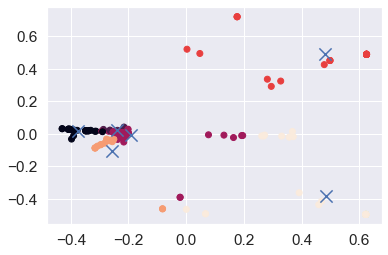

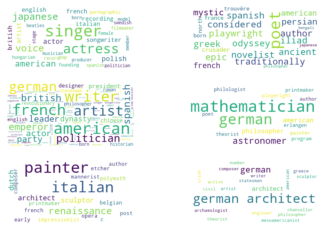

In [109]:
max_homogeneity = 0
for item in corpora:
    corpus = df_clean[['type','occupation',item]].copy()
    print('\n'+item+'\n')
    print('mode\tn_clusters\thomo\tcompl\tv-meas\tARI\tsilhouette')
    for n_cluster in n_clusters:
        for vect in vects:
            cls = cluster_texts(corpus, mode=vect, number_of_clusters=n_cluster)[1]
            X = cluster_texts(corpus, mode=vect, number_of_clusters=n_cluster)[0]
            homogeneity_score =evaluate_clusters(vect, n_cluster, X, cls)
            if homogeneity_score>max_homogeneity:
                max_homogeneity = homogeneity_score
                best_corpus = corpus
                best_cls = cls
                best_vect = vect
                best_n = n_cluster
                best_features = X
                clusters = cls.labels_
print(f'\n The best homogeneity_score was found clustering {best_corpus.columns[-1]} to {best_n} clusters using {best_vect} vectorizer')
print('\n Below you can see how these clusters look')
visualize(best_features,best_cls)

wordcloud(corpus,best_cls,best_n)

In [110]:
dist = 1 - cosine_similarity(best_features)
MDS()
# n_components=2 to plot results in a two-dimensional plane
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
xs, ys = pos[:, 0], pos[:, 1]
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#000000', 5:'#265682'}

#set up cluster names using a dict
cluster_names = {0: 'Singer', 
                 1: 'Writer', 
                 2: 'Painter', 
                 3: 'Architect',
                 4: 'Mathematician',
                 5: 'Politician'
                }

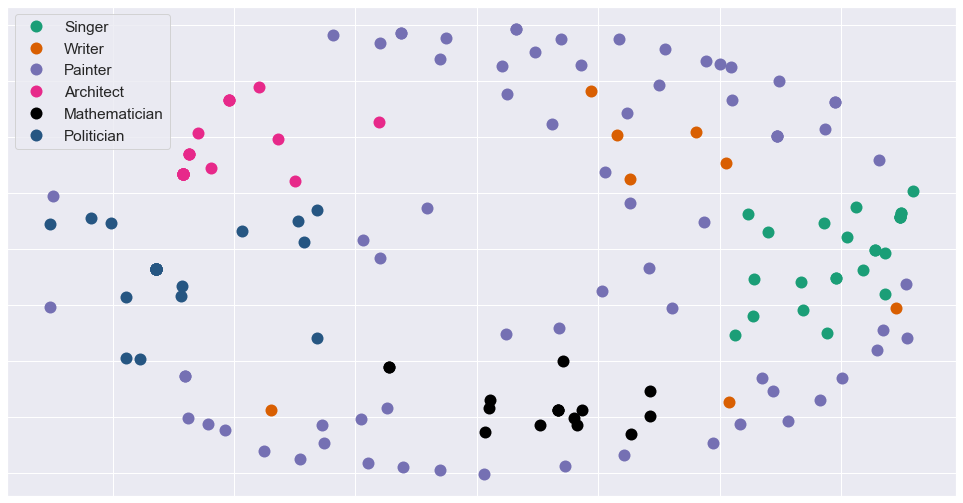

In [111]:
%matplotlib inline 

#creates data frame that has the result of the MDS plus the cluster numbers
df_viz = pd.DataFrame(dict(x=xs, y=ys, label=clusters))
groups = df_viz.groupby('label')

# creates the figure
fig, ax = plt.subplots(figsize=(17, 9)) 
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], 
            color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          
        which='both',      
        bottom=False,      
        top=False,         
        labelbottom=False)
    ax.tick_params(\
        axis= 'y',         
        which='both',      
        left=False,     
        top=False,        
        labelleft=False)
    
ax.legend(numpoints=1)  
plt.show() 


In [112]:
#classification function that returns the best accuracy from the following models
def classification(x, y):
    models = []
    models.append(('Logistic_Regression', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)))
    models.append(('Linear_SVC', OneVsRestClassifier(LinearSVC(), n_jobs=1)))
    models.append(('Multinomial Naive Bayes', OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None))))
    models.append(('Support_Vector_Classification', svm.SVC(C=1.0, kernel='linear', degree=3)))
    models.append(('RandomForestClassifier',RandomForestClassifier(n_estimators=1000, random_state= 42)))
    models.append(('Multi_layer_Perceptron', MLPClassifier(hidden_layer_sizes=210, max_iter=300, random_state=42)))
    
    x_train, x_test, y_train, y_test = \
    train_test_split(x, y, test_size=0.3, random_state= 42)
    accuracy_scores=[]
    for n,m in models: #train on TF-IDF vectors w/ and train on all models in the list 
        pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('classifier', m),  
        ])

        pipeline.fit(x_train,y_train)
        predictions = pipeline.predict(x_test)
        accuracy_scores.append((n,accuracy_score(y_test, predictions))) #append accuracy of every model in list
    
    #find the best accuracy
    best_score= max(accuracy_scores,key=lambda item:item[1])
    return best_score
    

In [113]:
#train models on the different preprocessing functions and get the best function with the best model
#calls classification function with the different preprocessed page content as x and the subcategories as y
#and stores the best score for each preprocessing function in variable
#append the variables of each function in best_scores list

best_scores=[]
preprocessing_1= classification(df_clean['pc_clean_preprocessing1'], df_clean['occupation'])
best_scores.append(('pc_clean_preprocessing1', preprocessing_1))
preprocessing_en_corpus= classification(df_clean['preprocessing_en_corpus'], df_clean['occupation'])
best_scores.append(('preprocessing_en_corpus', preprocessing_en_corpus))
preprocessing_non_ascii= classification(df_clean['preprocessing_non_ascii'], df_clean['occupation'])
best_scores.append(('preprocessing_non_ascii', preprocessing_non_ascii))
preprocessing_regex= classification(df_clean['preprocessing_regex'], df_clean['occupation'])
best_scores.append(('preprocessing_regex', preprocessing_regex))
    
#print (best_scores)  
best_score= max(best_scores,key=lambda item:item[1][1])
print('Best preprocessing function is {} with model {} and accuracy {}'.format((best_score[0]),(best_score[1][0]),(best_score[1][1])))
       

Best preprocessing function is pc_clean_preprocessing1 with model RandomForestClassifier and accuracy 0.8703703703703703


In [114]:
#returns the relevant wikidata description corpus
def description_preprocessing(k):
    d={'pc_clean_preprocessing1': 'description_preprocessing1',
      'preprocessing_en_corpus': 'description_preprocessing_en_corpus',
      'preprocessing_non_ascii': 'description_preprocessing_non_ascii',
      'preprocessing_regex': 'description_regex'}
    return (d.get(k))
description_preprocessing((best_score[0]))

'description_preprocessing1'

In [115]:
#compare different models and output dataframe with Accuracy, Precision macro_avg,Recall macro_avg and F1 Score macro_avg per model
def models_comparison(x, y):
    models = []
    models.append(('Logistic_Regression', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)))
    models.append(('Linear_SVC', OneVsRestClassifier(LinearSVC(), n_jobs=1)))
    models.append(('Multinomial Naive Bayes', OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None))))
    models.append(('Support_Vector_Classification', svm.SVC(C=1.0, kernel='linear', degree=3)))
    models.append(('RandomForestClassifier',RandomForestClassifier(n_estimators=1000, random_state= 42)))
    models.append(('Multi_layer_Perceptron', MLPClassifier(hidden_layer_sizes=210, max_iter=300, random_state=42)))
    
    x_train, x_test, y_train, y_test = \
    train_test_split(x, y, test_size=0.3, random_state= 42)
    accuracy_scores=[]
    precision_scores=[]
    recall_scores=[]
    f1_scores=[]
    for n,m in models:
        pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('classifier', m),
        ])

        pipeline.fit(x_train,y_train)
        predictions = pipeline.predict(x_test)
        accuracy_scores.append(accuracy_score(y_test, predictions))
        precision_scores.append(precision_score(y_test, predictions, average='macro'))  #append scores per model
        recall_scores.append(recall_score(y_test, predictions, average='macro'))
        f1_scores.append(f1_score(y_test, predictions, average='macro'))
    

    models_scores_table = pd.DataFrame({'Logistic Regression':[accuracy_scores[0].mean(),
                                                               precision_scores[0].mean(),
                                                               recall_scores[0].mean(),
                                                               f1_scores[0].mean()],
                                       
                                            'Linear SVC':[accuracy_scores[1].mean(),
                                                          precision_scores[1].mean(),
                                                          recall_scores[1].mean(),
                                                          f1_scores[1].mean()],
                                        
                                            'Multinomial Naive Bayes':[accuracy_scores[2].mean(),
                                                               precision_scores[2].mean(),
                                                               recall_scores[2].mean(),
                                                               f1_scores[2].mean()],
                                       
                                            'C-Support Vector Classification':[accuracy_scores[3].mean(),
                                                               precision_scores[3].mean(),
                                                               recall_scores[3].mean(),
                                                               f1_scores[3].mean()],
                                       
                                            'Random Forest Classifier':[accuracy_scores[4].mean(),
                                                               precision_scores[4].mean(),
                                                               recall_scores[4].mean(),
                                                               f1_scores[4].mean()],
                                        
                                            'Multi-layer Perceptron':[accuracy_scores[5].mean(),
                                                               precision_scores[5].mean(),
                                                               recall_scores[5].mean(),
                                                               f1_scores[5].mean()],},
                                      
                                            index=['Accuracy', 'Precision macro_avg', 'Recall macro_avg', 'F1 Score macro_avg'])
    
        # Add 'Best Score' column
    models_scores_table['Best Score'] = models_scores_table.idxmax(axis=1)
    
        # Return models performance metrics scores data frame
        
    return(models_scores_table)
        
  

In [116]:
#compare how each model performed under subcategories using our highest scored corpus
models_comparison(df_clean[best_score[0]], df_clean['occupation'])

,Logistic Regression,Linear SVC,Multinomial Naive Bayes,C-Support Vector Classification,Random Forest Classifier,Multi-layer Perceptron,Best Score
Accuracy,0.759259,0.777778,0.777778,0.814815,0.870370,0.777778,Random Forest Classifier
Precision macro_avg,0.753030,0.764141,0.771717,0.831439,0.876768,0.768038,Random Forest Classifier
Recall macro_avg,0.757672,0.774339,0.776190,0.813228,0.865079,0.770899,Random Forest Classifier
F1 Score macro_avg,0.742584,0.758709,0.762218,0.817675,0.863161,0.765468,Random Forest Classifier


In [117]:
#since we know that the Random Forest classifier gives the best results,
#we create a function that returns y_test, predictions and the confusion matrix in order to plot our results
def RFC(x, y):
    x_train, x_test, y_train, y_test = \
    train_test_split(x, y, test_size=0.3, random_state= 42)
    
    pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', RandomForestClassifier(n_estimators=1000, random_state= 42)),  # train on TF-IDF vectors w/ Random Forest classifier
    ])

    pipeline.fit(x_train,y_train)
    predictions = pipeline.predict(x_test)
    cm= confusion_matrix(y_test, predictions)
    return y_test, predictions, cm

#functions for other models,in case they give better results for other data

def classification_log_reg(x, y):
    x_train, x_test, y_train, y_test = \
    train_test_split(x, y, test_size=0.3, random_state= 42)
    
    LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
                ])
    
    
    # train the model using X_dtm & y
    LogReg_pipeline.fit(x_train, y_train)
    # compute the testing accuracy
    predictions = LogReg_pipeline.predict(x_test)
    cm= confusion_matrix(y_test, predictions)
    return y_test, predictions, cm

def classification_linear_SCV(x, y):
    x_train, x_test, y_train, y_test = \
    train_test_split(x, y, test_size=0.3, random_state= 42)
    
    pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
                ])

    pipeline.fit(x_train,y_train)
    predictions = pipeline.predict(x_test)
    cm= confusion_matrix(y_test, predictions)
    return y_test, predictions, cm

def classification_NB(x, y):
    x_train, x_test, y_train, y_test = \
    train_test_split(x, y, test_size=0.3, random_state= 42)
    
    pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])

    pipeline.fit(x_train,y_train)
    predictions = pipeline.predict(x_test)
    cm= confusion_matrix(y_test, predictions)
    return y_test, predictions, cm


def classification_SVC(x, y):
    x_train, x_test, y_train, y_test = \
    train_test_split(x, y, test_size=0.3, random_state= 42)
    
    pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('SVC', svm.SVC(C=1.0, kernel='linear', degree=3)),
            ])
    pipeline.fit(x_train,y_train)
    predictions = pipeline.predict(x_test)
    cm= confusion_matrix(y_test, predictions)
    return y_test, predictions, cm

def MLP(x, y):
    x_train, x_test, y_train, y_test = \
    train_test_split(x, y, test_size=0.3, random_state= 42)
    
    pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),    
    ('classifier', MLPClassifier(hidden_layer_sizes=210, max_iter=200, random_state=42)),
    ])

    pipeline.fit(x_train,y_train)
    predictions = pipeline.predict(x_test)
    cm= confusion_matrix(y_test, predictions)
    return y_test, predictions, cm

In [118]:
def plot_classification_report(y_tru, y_prd, figsize=(10, 10), ax=None):

    plt.figure(figsize=figsize)

    xticks = ['precision', 'recall', 'f1-score', 'support']
    yticks = list(np.unique(y_tru))
    yticks += ['avg']

    rep = np.array(precision_recall_fscore_support(y_tru, y_prd)).T
    avg = np.mean(rep, axis=0)
    avg[-1] = np.sum(rep[:, -1])
    rep = np.insert(rep, rep.shape[0], avg, axis=0)

    plot= sns.heatmap(rep,
                annot=True, 
                cbar=False, 
                xticklabels=xticks, 
                yticklabels=yticks,
                ax=ax)
    class_report= plot.set_title('Test accuracy is {}'.format(accuracy_score(y_tru, y_prd)))
    print (class_report)

In [119]:
def plot_cm(y_test, prediction):
    cm= confusion_matrix(y_test, prediction)
    df_cm = pd.DataFrame(cm, range(6), range(6))
    # plt.figure(figsize=(10,7))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

    plt.show()

In [120]:
def acc_per_subcategory(cm):
    per_class_accuracies = {}
    categories = ['Singer', 'Writer', 'Painter', 'Architect', 'Mathem', 'Politician']
    # Calculate the accuracy for each one of our classes
    for idx, cls in enumerate(categories):
        # True negatives are all the samples that are not our current GT class (not the current row) 
        # and were not predicted as the current class (not the current column)
        true_negatives = np.sum(np.delete(np.delete(cm, idx, axis=0), idx, axis=1))
    
        # True positives are all the samples of our current GT class that were predicted as such
        true_positives = cm[idx, idx]
    
        # The accuracy for the current class is ratio between correct predictions to all predictions
        per_class_accuracies[cls] = (true_positives + true_negatives) / np.sum(cm)
        
    values=[v for k,v in per_class_accuracies.items()]
    
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(categories,values)
    plt.title('Accuracy per subcategory')
    plt.show()

In [121]:
def acc_per_category(cm):
    per_class_accuracies = {}
    categories = ['A', 'Z']
    # Calculate the accuracy for each one of our classes
    for idx, cls in enumerate(categories):
        # True negatives are all the samples that are not our current GT class (not the current row) 
        # and were not predicted as the current class (not the current column)
        true_negatives = np.sum(np.delete(np.delete(cm, idx, axis=0), idx, axis=1))
    
        # True positives are all the samples of our current GT class that were predicted as such
        true_positives = cm[idx, idx]
    
        # The accuracy for the current class is ratio between correct predictions to all predictions
        per_class_accuracies[cls] = (true_positives + true_negatives) / np.sum(cm)
        
    values=[v for k,v in per_class_accuracies.items()]
   
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    
    ax.bar(categories,values)
    plt.title('Accuracy per category')
    plt.show()

In [122]:
#get y_test, predictions and confusion matrix for our page content and description
category_classification= RFC(df_clean[best_score[0]], df_clean['type']) 
subcategory_classification=RFC(df_clean[best_score[0]], df_clean['occupation'])
category_description_classification=RFC(df_clean[description_preprocessing((best_score[0]))], df_clean['type'])
subategory_description_classification=RFC(df_clean[description_preprocessing((best_score[0]))], df_clean['occupation'])

Text(0.5, 1.0, 'Test accuracy is 0.8518518518518519')


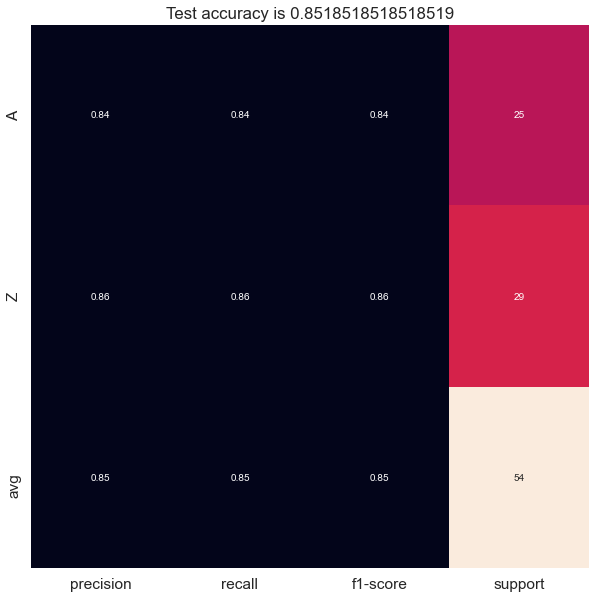

In [123]:
#plot classification report for categories with preprocessed page content
#category_classification[0] is the y_test and [1] the predictions
plot_classification_report(category_classification[0],category_classification[1])

Text(0.5, 1.0, 'Test accuracy is 0.8703703703703703')


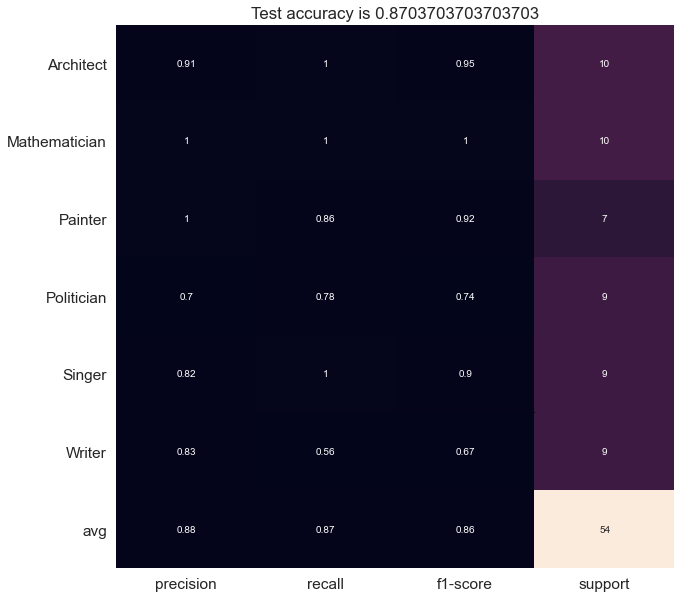

In [124]:
#plot classification report for subcategories with preprocessed page content
plot_classification_report(subcategory_classification[0],subcategory_classification[1])

Text(0.5, 1.0, 'Test accuracy is 0.8703703703703703')


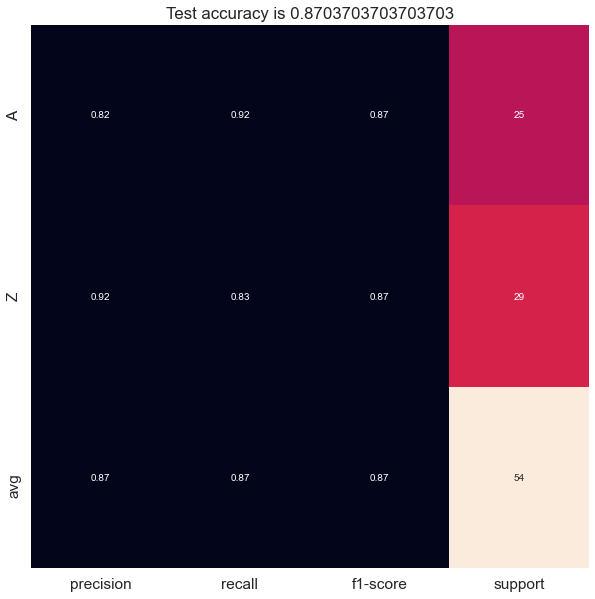

In [125]:
#plot classification report for categories with preprocessed wikidata description
plot_classification_report(category_description_classification[0],category_description_classification[1])

Text(0.5, 1.0, 'Test accuracy is 0.7777777777777778')


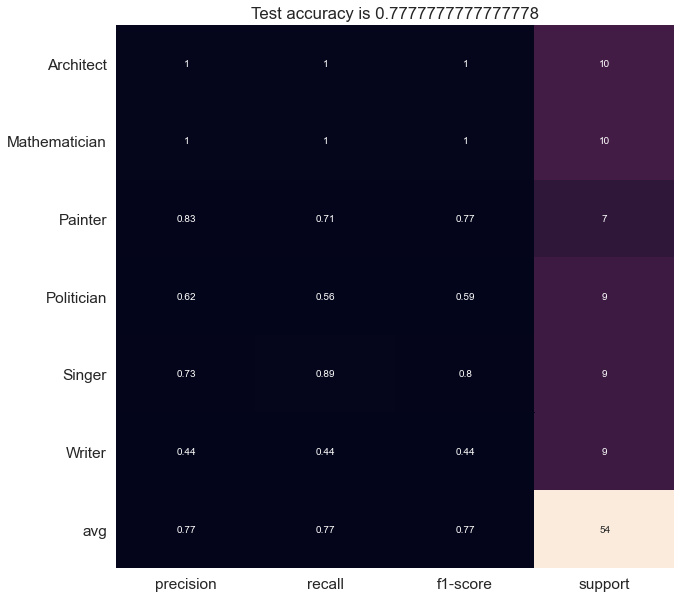

In [126]:
#plot classification report for subcategories with preprocessed wikidata desctiption
plot_classification_report(subategory_description_classification[0],subategory_description_classification[1])

In [127]:
#show confusion matrix for categories with preprocessed page content
print(category_classification[2])

[[21  4]
 [ 4 25]]


In [128]:
#show confusion matrix for categories with preprocessed wikidata description
print(category_description_classification[2])

[[23  2]
 [ 5 24]]


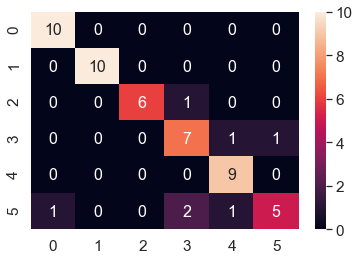

In [129]:
#show confusion matrix for subcategories with preprocessed page content
plot_cm(subcategory_classification[0],subcategory_classification[1])

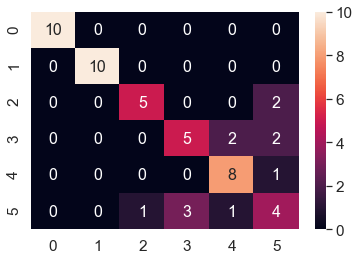

In [130]:
#show confusion matrix for subcategories with preprocessed wikidata description
plot_cm(subategory_description_classification[0],subategory_description_classification[1])

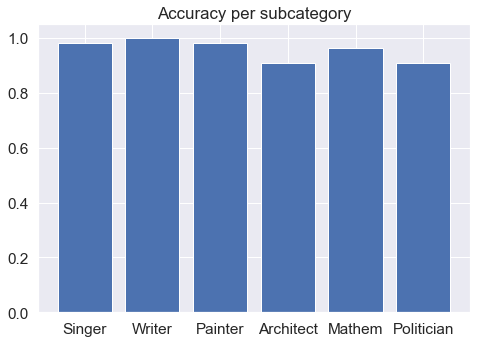

In [131]:
#print accuracy per subcategory
acc_per_subcategory(subcategory_classification[2])

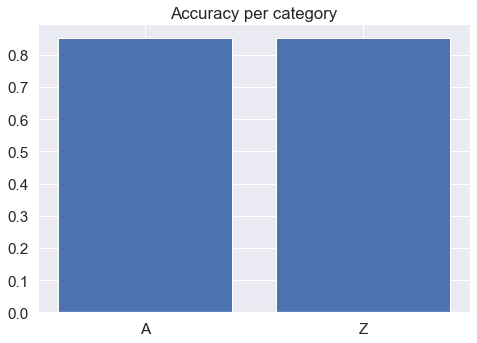

In [132]:
#print accuracy per category
acc_per_category(category_classification[2])